<a href="https://colab.research.google.com/github/cristobalperezp/Intro_Deep_Learning/blob/main/Tarea2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><strong>Tarea 2</strong></h1></center>
<center>Integrantes</center>
<center>Cristobal Pérez - Ignacio Henríquez - Michelle Avendaño - Tamara Vallejo</center>


<center>Curso</center>
<center>Introducción al Deep Learning</center>
<center>Profesor</center>
<center>Ángel Jiménez</center>
<center>Auxiliar</center>
<center>Rafael De La Sotta</center>
<center>Ayudantes </center>
<center>Camila Pulgar - Gabriela Mora - Maximiliano Rosadio - Patricio Ortiz - Sebastian Urbina </center>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf

import zipfile

import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###Descargar Datos###

In [3]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import pathlib
dataset_url = 'file:///content/drive/MyDrive/Universidad/10° Semestre/Intro al Deep Learning/Tareas/Tarea 2/cell_images.zip'
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='cell_images.zip',
                                   extract=True)
data_dir = pathlib.Path(data_dir)

367229291/367229291 [==============================] - 7s 0us/step


In [5]:
base_dir = os.path.join(os.path.dirname(data_dir), 'cell_images')

# Preprocesamiento

In [14]:
batch_size = 100
img_height = 150
img_width = 150

In [58]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [59]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [60]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


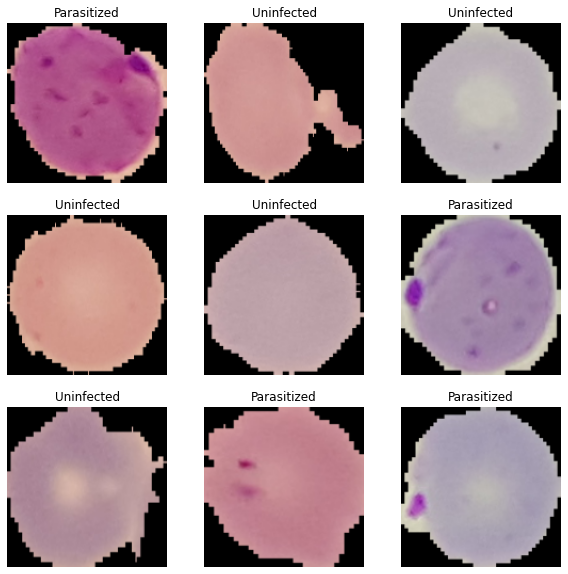

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

image_batch es un tensor de la forma (100, 150, 150, 3) . Este es un lote de 100 imágenes de forma 150x150x3 (la última dimensión se refiere a los canales de color RGB). El label_batch es un tensor de la forma (100,) , estas son las etiquetas correspondientes a las 100 imágenes.

In [62]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(100, 150, 150, 3)
(100,)


Se normalizan los datos

In [63]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [64]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [65]:
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ])

In [66]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [67]:
train_aug_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)